In [1]:
import os
import json
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Metrics obtained from an organizer of the Challenge
# https://github.com/plamere/RecsysChallengeTools/blob/master/metrics.py
from metrics import r_precision
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
playlists = list()
tracks = dict()
map_pl = list()

max_files_for_quick_processing = 100


def process_track(track):
    key = track['track_uri']
    if not key in tracks:
        tk = dict()
        tk['track_artist_name'] = track['artist_name']
        tk['track_artist_uri'] = track['artist_uri']
        tk['track_name'] = track['track_name']
        tk['track_album_uri'] = track['album_uri']
        tk['track_duration_ms'] = track['duration_ms']
        tk['track_album_name'] = track['album_name']
        tracks[track['track_uri']] = tk
    return key


def process_playlist(playlist):
    pl = dict()
    pl['playlist_name'] = playlist['name']
    pl['playlist_collaborative'] = playlist['collaborative']
    pl['playlist_pid'] = playlist['pid']
    pl['playlist_modified_at'] = playlist['modified_at']
    pl['playlist_num_albums'] = playlist['num_albums']
    pl['playlist_num_tracks'] = playlist['num_tracks']
    pl['playlist_num_followers'] = playlist['num_followers']
    pl['playlist_num_edits'] = playlist['num_edits']
    pl['playlist_duration_ms'] = playlist['duration_ms']
    pl['playlist_num_artists'] = playlist['num_artists']
    if 'description' in playlist:
        pl['playlist_description'] = playlist['description']
    else:
        pl['playlist_description'] = ''
    trks = list()
    for track in playlist['tracks']:
        map_pl.append([playlist['pid'], track['track_uri']])
        trks.append(track['track_uri'])
        process_track(track)
    return pl

def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            slice = json.loads(js)
            for playlist in slice['playlists']:
                playlists.append(process_playlist(playlist))
            count += 1
            if quick and count > max_files_for_quick_processing:
                break

quick = True
process_mpd('mpd.v1/data')

mpd.slice.0-999.json
mpd.slice.1000-1999.json
mpd.slice.10000-10999.json
mpd.slice.100000-100999.json
mpd.slice.101000-101999.json
mpd.slice.102000-102999.json
mpd.slice.103000-103999.json
mpd.slice.104000-104999.json
mpd.slice.105000-105999.json
mpd.slice.106000-106999.json
mpd.slice.107000-107999.json
mpd.slice.108000-108999.json
mpd.slice.109000-109999.json
mpd.slice.11000-11999.json
mpd.slice.110000-110999.json
mpd.slice.111000-111999.json
mpd.slice.112000-112999.json
mpd.slice.113000-113999.json
mpd.slice.114000-114999.json
mpd.slice.115000-115999.json
mpd.slice.116000-116999.json
mpd.slice.117000-117999.json
mpd.slice.118000-118999.json
mpd.slice.119000-119999.json
mpd.slice.12000-12999.json
mpd.slice.120000-120999.json
mpd.slice.121000-121999.json
mpd.slice.122000-122999.json
mpd.slice.123000-123999.json
mpd.slice.124000-124999.json
mpd.slice.125000-125999.json
mpd.slice.126000-126999.json
mpd.slice.127000-127999.json
mpd.slice.128000-128999.json
mpd.slice.129000-129999.json
mpd

In [3]:
print(len(playlists))
print(len(tracks))
print(len(map_pl))

101000
683816
6750280


In [4]:
playlist_df = pd.DataFrame(playlists)
playlist_df.head()
# print(playlist_df.describe())

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid
0,false,,11532414,1493424000,Throwbacks,47,37,6,1,52,0
1,false,,11656470,1506556800,Awesome Playlist,23,21,5,1,39,1
2,false,,14039958,1505692800,korean,51,31,18,1,64,2
3,false,,28926058,1501027200,mat,107,86,4,1,126,3
4,false,,4335282,1401667200,90s,16,16,7,2,17,4


In [5]:
tracks_df = pd.DataFrame.from_dict(tracks, orient='index')
tracks_df.head()
# print(tracks_df.describe())

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name
spotify:track:0000uJA4xCdxThagdLkkLR,Cherryholmes,spotify:artist:5kEVfWQGTw0rIDO2Jqq1ww,Heart As Cold As Stone,spotify:album:3SPMBGMEvPw21lmT5b1ApW,161186,Cherryholmes
spotify:track:00039MgrmLoIzSpuYKurn9,Zach Farlow,spotify:artist:2jTojc4rAsOMx6200a8Ah1,Thas What I Do,spotify:album:0UHfgx3ITlxePDXLaN5Y6x,222727,The Great Escape 2
spotify:track:0005w1bMJ7QAMl6DY98oxa,Dietrich Buxtehude,spotify:artist:2YfFYZnshSzgfLsKZMM4VL,"Sonata in G Major, BuxWV 271: Allegro -",spotify:album:6oRWciCAwKegipcCc5FlWe,111573,"Chamber Music: London Baroque - Rosenmuller, J..."
spotify:track:0007AYhg2UQbEm88mxu7js,Little Simz,spotify:artist:6eXZu6O7nAUA5z6vLV8NKI,Mandarin Oranges Part 2,spotify:album:32RJzqlapfiU0fr2l4SSW9,198000,E.D.G.E
spotify:track:000CTwOSsvRs0bgXlwB64e,Celly Cel,spotify:artist:6k7TX5dxiKZiwMWTn8ZKbl,Shady World,spotify:album:6LOmO9x8uPwlc3gSXZqqi8,155238,The Lost Tapes


In [6]:
playlist_map_df = pd.DataFrame(map_pl, columns=['playlist_pid', 'track_uri'])
playlist_map_df.head()
#print(playlist_map_df.describe())

,playlist_pid,track_uri
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H


We set strings to lower case remove all non alphabetic characters and stop-words

In [7]:
import nltk
import string
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
ignored_words = ['music',
'songs',
'playlist',
'good',
'jams',
'mix',
'lit',
'best',
'stuff',
'quot',
'like',
'one',
'amp',
'get',
'make',
'new',
'know',
'really',
'back',
'day',
'days',
'little',
'things',
'great',
'everything',
'jamz',
'tunes',
'artist',
'song',
'top',
'listen',
'favorite',
'bops',
'description',
'top',
'ever',
'mostly',
'enjoy',
'bunch',
'track',
'tracks',
'collection',
'need',
'every',
'favorites',
'may',
'got',
'right',
'let',
'better',
'made'
]

def word_cleanup(df_col):
    df_col = df_col.apply(lambda x: x.lower())
    df_col = df_col.str.replace('[^a-z]+', ' ')
    df_col = df_col.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df_col = df_col.apply(lambda x: ' '.join([word for word in x.split() if word not in (ignored_words)]))
    df_col = df_col.str.replace(r'\b\w{1,2}\b', '').str.replace(r'\s+', ' ')
    return df_col

playlist_df.playlist_description = word_cleanup(playlist_df.playlist_description)
playlist_df.playlist_name = word_cleanup(playlist_df.playlist_name)

#playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: x.lower())
#playlist_df.playlist_name = playlist_df.playlist_name.str.replace('[^a-z]+', ' ')
#playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

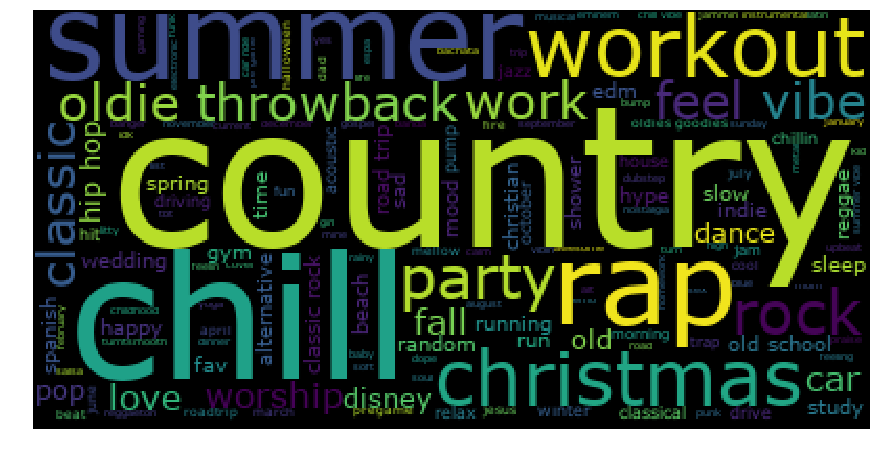

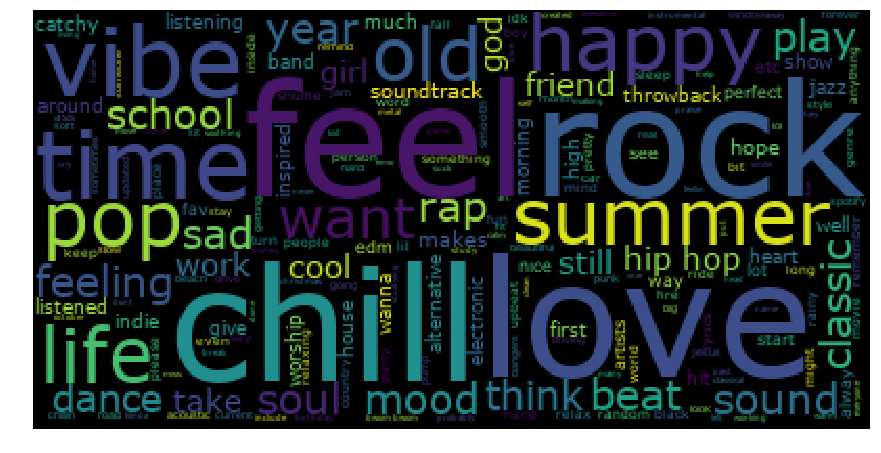

In [8]:
#pip install wordcloud
from wordcloud import WordCloud

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 0.1,
                          ).generate(text)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(' '.join(playlist_df.playlist_name))

generate_wordcloud(' '.join(playlist_df.playlist_description))

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv_description = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_description = cv_description.fit_transform(playlist_df.playlist_description)
playlist_df['playlist_description_frequency'] = list(dt_mat_description.toarray())

cv_name = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_name = cv_name.fit_transform(playlist_df.playlist_name)
playlist_df['playlist_name_frequency'] = list(dt_mat_name.toarray())

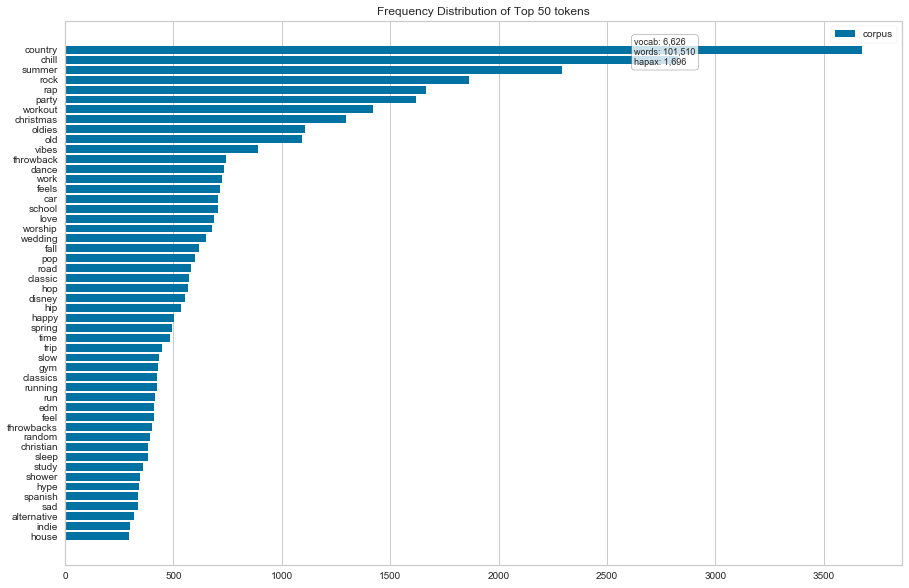

In [10]:
#pip install yellowbrick
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(15,20))
visualizer = FreqDistVisualizer(n=100, features = cv_name.get_feature_names())
visualizer.fit(dt_mat_name)
visualizer.poof()

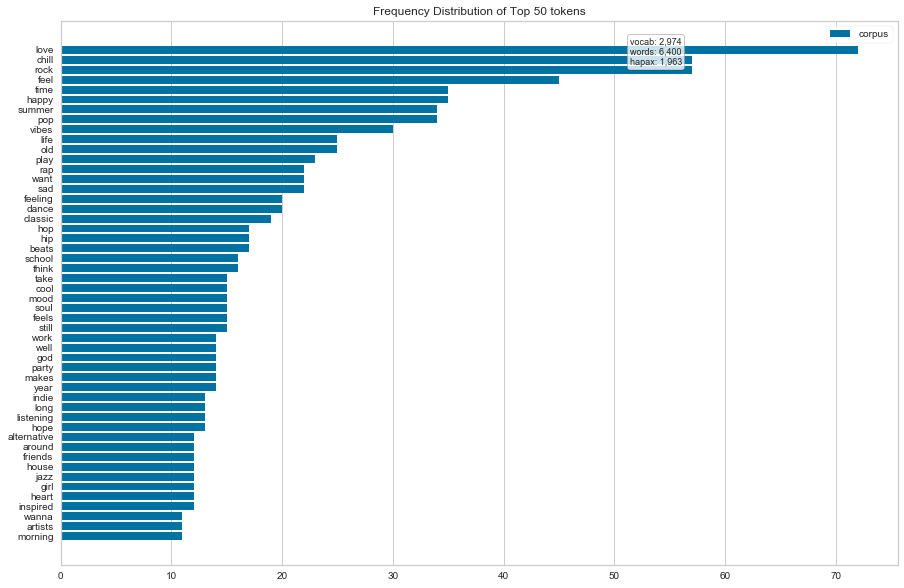

In [11]:
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(15,20))
visualizer = FreqDistVisualizer(n=100, features = cv_description.get_feature_names())
visualizer.fit(dt_mat_description)
visualizer.poof()

In [12]:
tfidf_transformer = TfidfTransformer()

tfidf_mat_description = tfidf_transformer.fit_transform(dt_mat_description)
playlist_df['playlist_description_tfidf_score']=list(tfidf_mat_description.toarray())

tfidf_mat_name = tfidf_transformer.fit_transform(dt_mat_name)
playlist_df['playlist_name_tfidf_score']=list(tfidf_mat_name.toarray())
playlist_df

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid,playlist_description_frequency,playlist_name_frequency,playlist_description_tfidf_score,playlist_name_tfidf_score
0,false,,11532414,1493424000,throwbacks,47,37,6,1,52,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,false,,11656470,1506556800,awesome,23,21,5,1,39,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,false,,14039958,1505692800,korean,51,31,18,1,64,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,false,,28926058,1501027200,mat,107,86,4,1,126,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,false,,4335282,1401667200,,16,16,7,2,17,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,false,,19156557,1430956800,wedding,71,56,3,1,80,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,false,,3408479,1477094400,put spell,15,13,2,1,16,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,false,,12674796,1509321600,,52,48,38,1,53,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,false,,9948921,1508976000,bop,37,23,21,2,46,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,false,,4297488,1501804800,old country,20,18,10,1,21,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [13]:
bigrams_name_frequency = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_frequency)

bigrams_desc_frequency = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_frequency)

bigrams_name_tfidf_score = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_tfidf_score)

bigrams_desc_tfidf_score = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_tfidf_score)

        aaa  aaaa  aaaaa  aaaaaa  aaaaaaa  aaaaaaaaa  aaliyah  aaron  abajo  \
0         0     0      0       0        0          0        0      0      0   
1         0     0      0       0        0          0        0      0      0   
2         0     0      0       0        0          0        0      0      0   
3         0     0      0       0        0          0        0      0      0   
4         0     0      0       0        0          0        0      0      0   
5         0     0      0       0        0          0        0      0      0   
6         0     0      0       0        0          0        0      0      0   
7         0     0      0       0        0          0        0      0      0   
8         0     0      0       0        0          0        0      0      0   
9         0     0      0       0        0          0        0      0      0   
10        0     0      0       0        0          0        0      0      0   
11        0     0      0       0        0          0

        aaaaaaahhhhhhhhhhhhhhh  aang  aaron  abandoned  abba  abc  able  \
0                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
1                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
2                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
3                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
4                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
5                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
6                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
7                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
8                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
9                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
10                         0.0   0.0    0.0        0.0   0.0  0.0   0.0   
11                         0.0   0.0    0.0        0.0   0.0  0.0   0.0   
12                       

        aaa  aaaa  aaaaa  aaaaaa  aaaaaaa  aaaaaaaaa  aaliyah  aaron  abajo  \
0         0     0      0       0        0          0        0      0      0   
1         0     0      0       0        0          0        0      0      0   
2         0     0      0       0        0          0        0      0      0   
3         0     0      0       0        0          0        0      0      0   
4         0     0      0       0        0          0        0      0      0   
5         0     0      0       0        0          0        0      0      0   
6         0     0      0       0        0          0        0      0      0   
7         0     0      0       0        0          0        0      0      0   
8         0     0      0       0        0          0        0      0      0   
9         0     0      0       0        0          0        0      0      0   
10        0     0      0       0        0          0        0      0      0   
11        0     0      0       0        0          0

        aaaaaaahhhhhhhhhhhhhhh  aang  aaron  abandoned  abba  abc  able  \
0                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
1                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
2                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
3                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
4                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
5                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
6                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
7                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
8                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
9                          0.0   0.0    0.0        0.0   0.0  0.0   0.0   
10                         0.0   0.0    0.0        0.0   0.0  0.0   0.0   
11                         0.0   0.0    0.0        0.0   0.0  0.0   0.0   
12                       

In [14]:
merged = pd.merge(
    pd.merge(
        tracks_df, playlist_map_df, left_index=True, right_on='track_uri'),
    playlist_df,
    on='playlist_pid')

In [15]:
merged.head()

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,playlist_pid,track_uri,playlist_collaborative,playlist_description,...,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_description_frequency,playlist_name_frequency,playlist_description_tfidf_score,playlist_name_tfidf_score
0,Cherryholmes,spotify:artist:5kEVfWQGTw0rIDO2Jqq1ww,Heart As Cold As Stone,spotify:album:3SPMBGMEvPw21lmT5b1ApW,161186,Cherryholmes,153150,spotify:track:0000uJA4xCdxThagdLkkLR,false,,...,bluegrass,25,20,3,2,35,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Cherryholmes,spotify:artist:5kEVfWQGTw0rIDO2Jqq1ww,How Long,spotify:album:3SPMBGMEvPw21lmT5b1ApW,211013,Cherryholmes,153150,spotify:track:05ynpl3ToWx4UTnKeJUCC1,false,,...,bluegrass,25,20,3,2,35,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Catfish Keith,spotify:artist:2ac6h7fMKfNyB4FDBGpCYL,"Dark Was The Night, Cold Was The Ground",spotify:album:1zMt5qoqzBlmN59QQM5ND7,342066,"Twist It, Babe!",153150,spotify:track:0XRtJYql9GFDPOb6088YaH,false,,...,bluegrass,25,20,3,2,35,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,The Del McCoury Band,spotify:artist:2fj5pzLyOKDpUOPZs9q3wt,Can't You Hear Me Callin',spotify:album:1DjDJoxIpjBoLoS8kBkLOV,249506,True Life Blues: The Songs Of Bill Monroe,153150,spotify:track:1EYTsenPJf1uFS4AGg09HN,false,,...,bluegrass,25,20,3,2,35,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,The Band Of Heathens,spotify:artist:5K4gVy6DhNd39mSjuK95Y7,Jackson Station,spotify:album:2uLWOOdPAcxIjH3vvJDWNX,232893,The Band Of Heathens,153150,spotify:track:1HcV9P8MnklEbDNk3CNdNg,false,,...,bluegrass,25,20,3,2,35,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# Create Negative Samples
negative_samples = pd.DataFrame([])
for pid, df in tqdm(merged.groupby(["playlist_pid"])):
    negative_tracks = tracks_df.drop(df.track_uri).sample(df.shape[0])
    negative_playlist_tracks = pd.concat(
        [
            df.drop(list(tracks_df.columns) + ['track_uri'], axis=1).reset_index(
                drop=True), negative_tracks.reset_index()
        ],
        axis=1)
    negative_playlist_tracks.rename(columns={'index': 'track_uri'}, inplace=True)
    negative_samples = negative_samples.append(negative_playlist_tracks)


In [ ]:
# Provide labels
negative_samples['match'] = 0
merged['match'] = 1

In [ ]:
negative_samples.head()

In [ ]:
merged.head()

In [ ]:
negative_samples.head()

In [ ]:
merged.columns

In [ ]:
negative_samples.columns

In [ ]:
dataset = merged.append(negative_samples[merged.columns]).sort_values(by=['playlist_pid']).reset_index(drop=True)

In [ ]:
dataset.tail(32)

In [ ]:
# Include the features in the list below
features = [
    'playlist_duration_ms', 'playlist_num_albums', 'playlist_num_artists',
    'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
    'playlist_pid', 'track_duration_ms'
]
data_x = dataset[features]
data_y = dataset.match
X_train, X_test, y_train, y_test = train_test_split(
    data_x,
    data_y,
    test_size=0.1,
    stratify=dataset.playlist_pid,
    random_state=42,
    shuffle=True)

The dataset has been split, which is great. However, in order to better simulate real world situations, we need to build a test set with a lot more negative samples than there are positive samples. In the split above, there are equal number of positive and negative samples, so it'll be easy for the algorithm to perform. Below we build a more robust test set

In [ ]:
X_train.columns

In [ ]:
X_test_refined.head()

In [ ]:
y_test.head()
# y_test[y_test == 1].head()

In [ ]:
dataset.loc[X_test.head().index]

In [ ]:
# 1. Calculate metric only on test set using the positive samples
#     a. Obtain unique playlists in the test set
#     b. For each playlist, obtain the positve songs.
#     c. Set both `target` and `prediction` as lists of the positive songs
#     d. For each playlist, calculate the r_precision. r_precision comes from the metrics.py file in the repo.

# 2. Train the X_train on the classifier. Obtain predictions for X_test

# 3. Repeat 1 above, now setting `predictions` as the list of songs "ranked by probability".

# 4. Calculate the r_precision metric based on your predicitons!

In [ ]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    probs = y_test.loc[df.index]  # change y_test to the output probs from clf
    targets = dataset.loc[probs[probs == 1].index].track_uri
    predictions = dataset.loc[probs[probs > 0.5].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

In [ ]:
X_train_norm = (X_train-X_train.mean())/X_train.std()
X_test_norm = (X_test-X_test.mean())/X_test.std()

In [ ]:
X_train_norm.head()

In [ ]:
X_test_norm.head()

In [ ]:
lr_clf = LogisticRegression()
lr_clf = lr_clf.fit(X_train_norm, y_train)

In [ ]:
# y_prob = lr_clf.predict_proba(X_test)
y_prob = pd.DataFrame(lr_clf.predict_proba(X_test_norm), index=y_test.index)

In [ ]:
y_prob.head(10)

In [ ]:
y_test.head(10)

In [ ]:
y_pred = y_prob.idxmax(axis=1)

In [ ]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    labels = y_test.loc[df.index]  # change y_test to the output probs from clf
    preds = y_pred.loc[df.index]
    targets = dataset.loc[labels[labels == 1].index].track_uri
    predictions = dataset.loc[preds[preds == 1].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

In [ ]:
X_test_refined = pd.DataFrame([])
r_precisions = []
pbar = tqdm(X_test.groupby(['playlist_pid']))
for pid, df in pbar:
    labels = y_test.loc[df.index]
    targets = dataset.loc[labels.index].track_duration_ms
    positive_targets = dataset.loc[labels[labels == 1].index].index
    # trained_idx = set(y_train[y_train == 1].index) - set(df.index)
    # Obtain all tracks from dataset which are not in the playlist under consideration
    #     negative_tracks = dataset.loc[X_train[(X_train.playlist_pid != pid)]
    #                                   .index].track_duration_ms
    negative_tracks = dataset.loc[X_test[(X_test.playlist_pid != pid)]
                                  .index].track_duration_ms
    # trained_tracks = X_train.loc[y_train.loc[y_train[y_train==1].index].index].track_uri
    new_df = df.drop('track_duration_ms', axis=1)
    new_test = negative_tracks.append(targets)
    new_df = pd.concat([new_df.head(1)] * len(new_test))
    test_playlist_tracks = pd.concat(
        [new_df.reset_index(drop=True), new_test.reset_index(drop=True)],
        axis=1).set_index(new_test.index)
    # from IPython.core.debugger import set_trace; set_trace()
    test_playlist_tracks = (test_playlist_tracks-test_playlist_tracks.mean())/(test_playlist_tracks.std()+1e-8)
    X_test_refined = X_test_refined.append(test_playlist_tracks)
    y_prob = pd.DataFrame(
        lr_clf.predict_proba(test_playlist_tracks),
        index=test_playlist_tracks.index)
    y_prob = y_prob.sort_values(by=[1], ascending=False)
    if len(positive_targets) > 0:
        r_precisions.append(r_precision(positive_targets, y_prob.index))
    pbar.set_description("{}".format(np.mean(r_precisions)))
    # from IPython.core.debugger import set_trace; set_trace()

In [ ]:
np.unique(r_precisions, return_counts=True)

In [ ]:
np.mean(r_precisions)

Question: Do playlist and track duration interact to influence whether a song should belong to a playlist `(match=1)` or whether a song should not belong to a playlist `(match=0)`?

In [ ]:
(dataset[dataset.match==1].playlist_duration_ms/dataset[dataset.match==1].playlist_num_tracks)

In [ ]:
plt.scatter(dataset[dataset.match == 1].playlist_duration_ms /
            dataset[dataset.match == 1].playlist_num_tracks,
            dataset[dataset.match == 1].track_duration_ms)
plt.scatter(dataset[dataset.match == 0].playlist_duration_ms /
            dataset[dataset.match == 0].playlist_num_tracks,
            dataset[dataset.match == 0].track_duration_ms)
plt.xlabel('Average Track Duration')
plt.ylabel('Track Duration')


A trend which might not be that strong to notice is that as the average track duration increases for a playlist, the propensity to see a track of long duration increases. However, this isn't the case with negative sample playlists, where in playlist of short length very long tracks can still be detected.

In [ ]:
plt.hist(dataset[dataset.match==1].playlist_duration_ms)
plt.hist(dataset[dataset.match==0].playlist_duration_ms)